Install & Import Necessary Packages

In [1]:
%pip install numpy pandas seaborn matplotlib scikit-learn imblearn xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, accuracy_score,confusion_matrix, f1_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from itertools import combinations
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

Data Preprocessing

In [3]:
df = pd.read_csv('Creditcardanalysis.csv')

In [4]:
print("original", len(df))

original 6362620


In [5]:
#Filter 1
df = df[df['type'].isin(['TRANSFER', 'CASH_OUT'])]
print("Solo Cash Outs and Transfers:", len(df))

#Filter 2
df = df[df['amount'] > 100000]
print("Remove Operations > 100,000:", len(df))

Solo Cash Outs and Transfers: 2770409
Remove Operations > 100,000: 1934297


In [6]:
#Fraud Proportion
(len(df[df['isFraud'] == 1]) / len(df))*100

0.33634958850683216

In [7]:
sns.set_style("whitegrid")
sns.set_palette("GnBu_d")
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 11

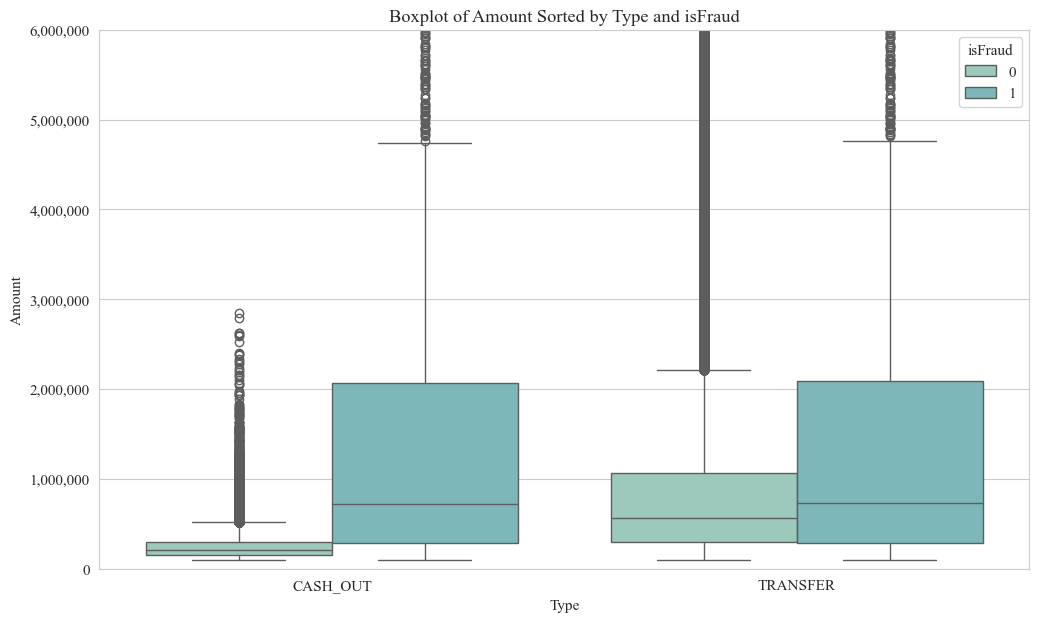

In [8]:
#BoxPlot
plt.figure(figsize=(12, 7))
ax = sns.boxplot(x='type', y='amount', hue='isFraud', data=df)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.set_ylim(0, 6000000)  # Set y-axis limit to 10,000,000
plt.title('Boxplot of Amount Sorted by Type and isFraud')
plt.xlabel('Type')
plt.ylabel('Amount')
plt.legend(title='isFraud')

plt.show()

In [9]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 11

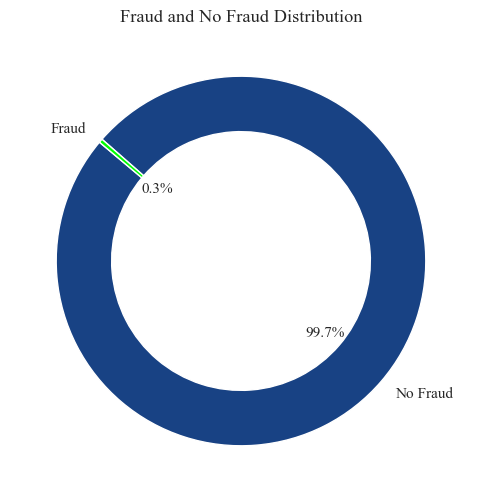

In [10]:
fraud_counts = df['isFraud'].value_counts()
colors = ['#184284', '#00FF00']
plt.figure(figsize=(8, 6))
labels = ['No Fraud', 'Fraud']  
plt.pie(fraud_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.3, edgecolor='w'))
plt.title('Fraud and No Fraud Distribution')
plt.show()

In [11]:
df = df.drop(columns=(['isFlaggedFraud']))

Feature Engineering

In [12]:
#CConstants
SMALL_CONSTANT = 1e-5
EXP_MAX = 10
SQUARE_MAX = 1e5
original_vars = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

In [13]:
#Non-linear transformations
for var in original_vars:
    df[f'{var}_squared'] = np.where(df[var] < SQUARE_MAX, df[var]**2, df[var])
    df[f'{var}_log'] = np.log1p(df[var])
    df[f'{var}_exp'] = np.exp(np.minimum(df[var], EXP_MAX)) #Applying a maximum value for exponentiation
    df[f'{var}_sqrt'] = np.sqrt(df[var])

In [14]:
#More transformations
df['exp_x'] = np.exp(df['amount'])
df['sqrt_c'] = np.sqrt(df['oldbalanceDest'])
df['x_over_y'] = df['amount'] / (df['oldbalanceDest'] + SMALL_CONSTANT)

e:\miniconda3\envs\CreditCardFraud\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [15]:
#Multiplications
combo_vars = []
for combo in combinations(original_vars, 2):
    new_var = f"{combo[0]}_x_{combo[1]}"
    df[new_var] = df[combo[0]] * df[combo[1]]
    combo_vars.append(new_var)

In [16]:
#Ratios
ratio_vars = []
for combo in combinations(original_vars, 2):
    new_var = f"{combo[0]}_div_{combo[1]}"
    df[new_var] = df[combo[0]] / (df[combo[1]] + SMALL_CONSTANT)
    ratio_vars.append(new_var)

In [17]:
#One-Hot Encoding
encoder = OneHotEncoder(drop='first', sparse_output=False)
type_encoded = encoder.fit_transform(df[['type']])
if hasattr(encoder, 'get_feature_names_out'):
    column_names = encoder.get_feature_names_out(input_features=['type'])
else:
    column_names = encoder.get_feature_names(input_features=['type'])
df_type_encoded = pd.DataFrame(type_encoded, columns=column_names, index=df.index)
df = pd.concat([df, df_type_encoded], axis=1)
print("Final number of features:", df.shape[1])

Final number of features: 54


In [18]:
#Drop the variables that generate noise
columns_to_drop = [
    'exp_x','step',
    'oldbalanceDest_x_newbalanceDest',
    'amount_x_newbalanceDest',
    'amount_x_oldbalanceDest',
    'oldbalanceOrg_x_newbalanceOrig',
    'amount_x_oldbalanceOrg',
    'amount_x_newbalanceOrig',
    'oldbalanceOrg_x_newbalanceDest',
    'oldbalanceOrg_x_oldbalanceDest',
    'newbalanceOrig_x_newbalanceDest',
    'newbalanceOrig_x_oldbalanceDest',
    'amount_over_newbalanceOrig',
    'x_over_y',
    'amount_over_oldbalanceOrg',
    'amount_over_oldbalanceDest',
    'oldbalanceOrg_over_oldbalanceDest',
    'oldbalanceOrg_over_newbalanceDest',
    'newbalanceOrig_over_oldbalanceDest',
    'newbalanceOrig_over_newbalanceDest',
    'oldbalanceOrg_over_newbalanceOrig',
    'amount_over_newbalanceDest',
    'oldbalanceDest_over_newbalanceDest', 'sqrt_c', 
]

# Filter out columns that are not present in the dataframe
columns_to_drop = [col for col in columns_to_drop if col in df.columns]

df.drop(columns=columns_to_drop, inplace=True)

In [19]:
#Train-Test Split
X = df.drop('isFraud', axis=1)
y = df['isFraud']

In [20]:
#Train-Test Split 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

SMOTE

In [21]:
cols_to_drop = ['type', 'nameOrig', 'nameDest']
X_train_dropped = X_train.drop(cols_to_drop, axis=1, errors='ignore')
X_test_dropped = X_test.drop(cols_to_drop, axis=1, errors='ignore')

In [22]:
#SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_dropped, y_train)
column_names = X_train_smote.columns

e:\miniconda3\envs\CreditCardFraud\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "e:\miniconda3\envs\CreditCardFraud\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "e:\miniconda3\envs\CreditCardFraud\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\miniconda3\envs\CreditCardFraud\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "e:\miniconda3\envs\CreditCardFraud\Lib\subprocess.py", line 1538, in _exec

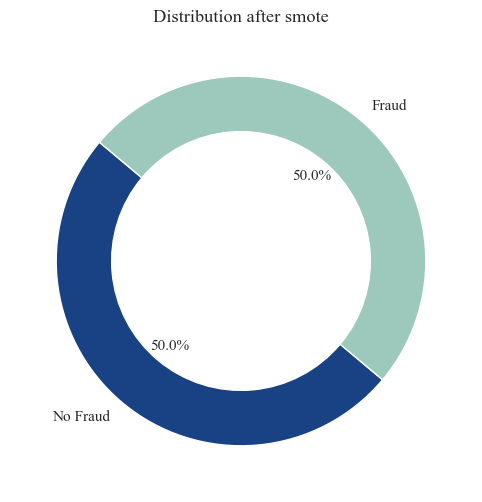

In [23]:
#Graph after SMOTE
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 11
fraud_counts = y_train_smote.value_counts()
colors = ['#184284', '#9CC9BC'] 
plt.figure(figsize=(8, 6))
labels = ['No Fraud', 'Fraud'] 
plt.pie(fraud_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.3, edgecolor='w'))
plt.title('Distribution after smote')
plt.show()

Model Comparison

Logit

In [24]:
#Data scaling
scaler = StandardScaler()
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test_dropped)

In [25]:
#Logit
logit_model = LogisticRegression(max_iter=10000)
logit_model.fit(X_train_smote_scaled, y_train_smote)
feature_names = column_names
coefficients = logit_model.coef_[0]
coeff_summary = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
print(coeff_summary)

                              Feature   Coefficient
0                              amount -2.411656e+01
1                       oldbalanceOrg  3.001144e+01
2                      newbalanceOrig -3.451469e+01
3                      oldbalanceDest  3.648248e+00
4                      newbalanceDest -4.360144e+00
5                      amount_squared -2.411656e+01
6                          amount_log -1.499335e+01
7                          amount_exp  1.452850e-09
8                         amount_sqrt  3.118997e+01
9               oldbalanceOrg_squared -8.163148e-01
10                  oldbalanceOrg_log  1.745460e+00
11                  oldbalanceOrg_exp -1.895592e+00
12                 oldbalanceOrg_sqrt  1.822260e+01
13             newbalanceOrig_squared -9.064636e+00
14                 newbalanceOrig_log  1.967863e+01
15                 newbalanceOrig_exp -1.684837e+01
16                newbalanceOrig_sqrt -1.715512e+01
17             oldbalanceDest_squared -3.200473e-02
18          

In [26]:
logit_model = LogisticRegression(max_iter=10000)
logit_model.fit(X_train_smote_scaled, y_train_smote)
logit_prob_predictions = logit_model.predict_proba(X_test_scaled)[:, 1]

# Different threshold
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
f1_scores = {}

for thresh in thresholds:
    logit_predictions = (logit_prob_predictions > thresh).astype(int)
    f1 = f1_score(y_test, logit_predictions)
    f1_scores[thresh] = f1
    print(f"F1 Score for Threshold {thresh}: {f1}")

best_thresh = max(f1_scores, key=f1_scores.get)
print(f"Best Threshold = {best_thresh}")

F1 Score for Threshold 0.1: 0.25270897832817335
F1 Score for Threshold 0.2: 0.2900610771793448
F1 Score for Threshold 0.3: 0.32183341547560373
F1 Score for Threshold 0.4: 0.3521639476877444
F1 Score for Threshold 0.5: 0.38355359765051394
F1 Score for Threshold 0.6: 0.42049299178347027
F1 Score for Threshold 0.7: 0.469571480014404
F1 Score for Threshold 0.8: 0.5507185122569738
F1 Score for Threshold 0.9: 0.7011049723756906
F1 Score for Threshold 0.99: 0.86530931871574
Best Threshold = 0.99


In [27]:
logit_prob_predictions = logit_model.predict_proba(X_test_scaled)[:, 1]
# threshold 0.99
logit_predictions_99 = (logit_prob_predictions > 0.99).astype(int)
conf_matrix_99 = confusion_matrix(y_test, logit_predictions_99)
print(f"Confusion matrix at threshold = 0.99:")
print(conf_matrix_99)

Confusion matrix at threshold = 0.99:
[[385411    139]
 [   205   1105]]


In [28]:
print(classification_report(y_test, logit_predictions_99))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    385550
           1       0.89      0.84      0.87      1310

    accuracy                           1.00    386860
   macro avg       0.94      0.92      0.93    386860
weighted avg       1.00      1.00      1.00    386860



Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train_smote, y_train_smote)
rf_predictions = rf_model.predict(X_test_dropped)

In [30]:
rf_prob_predictions = rf_model.predict_proba(X_test_dropped)[:, 1]

In [31]:
#Different Thresholds
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
f1_scores_rf = {}
for thresh in thresholds:
    rf_predictions_thresh = (rf_prob_predictions > thresh).astype(int)
    f1_rf = f1_score(y_test, rf_predictions_thresh)
    f1_scores_rf[thresh] = f1_rf
print("F1 scores for different Random Forest thresholds:")
for thresh, f1 in f1_scores_rf.items():
    print(f"Threshold = {thresh}: F1 score = {f1}")

F1 scores for different Random Forest thresholds:
Threshold = 0.1: F1 score = 0.945309670409272
Threshold = 0.2: F1 score = 0.9652366863905325
Threshold = 0.3: F1 score = 0.9709821428571429
Threshold = 0.4: F1 score = 0.9767964071856288
Threshold = 0.5: F1 score = 0.980465815176559
Threshold = 0.6: F1 score = 0.9863945578231292
Threshold = 0.7: F1 score = 0.9886363636363636
Threshold = 0.8: F1 score = 0.9916413373860182
Threshold = 0.9: F1 score = 0.9869831546707504
Threshold = 0.99: F1 score = 0.9463570856685348


In [32]:
rf_predictions_90 = (rf_prob_predictions > 0.9).astype(int)
conf_matrix_90 = confusion_matrix(y_test, rf_predictions_90)
print("Confusion matrix at threshold = 0.9:")
print(conf_matrix_90)
print(classification_report(y_test, rf_predictions_90))

Confusion matrix at threshold = 0.9:
[[385537     13]
 [    21   1289]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    385550
           1       0.99      0.98      0.99      1310

    accuracy                           1.00    386860
   macro avg       0.99      0.99      0.99    386860
weighted avg       1.00      1.00      1.00    386860



In [33]:
#XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_smote, y_train_smote)
xgb_prob_predictions = xgb_model.predict_proba(X_test_dropped)[:, 1]

e:\miniconda3\envs\CreditCardFraud\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:28:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [34]:
#thresholds
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
f1_scores_xgb = {}

In [35]:
for thresh in thresholds:
    xgb_predictions_thresh = (xgb_prob_predictions > thresh).astype(int)
    f1_xgb = f1_score(y_test, xgb_predictions_thresh)
    f1_scores_xgb[thresh] = f1_xgb

In [36]:
# Print F1 scores for each threshold
print("F1 scores for different XGBoost thresholds:")
for thresh, f1 in f1_scores_xgb.items():
    print(f"Threshold = {thresh}: F1 score = {f1}")

F1 scores for different XGBoost thresholds:
Threshold = 0.1: F1 score = 0.8503423540919465
Threshold = 0.2: F1 score = 0.857331571994716
Threshold = 0.3: F1 score = 0.8618968386023295
Threshold = 0.4: F1 score = 0.8687479019805304
Threshold = 0.5: F1 score = 0.8723332204537758
Threshold = 0.6: F1 score = 0.8805203697363917
Threshold = 0.7: F1 score = 0.8918260869565218
Threshold = 0.8: F1 score = 0.8996125396266291
Threshold = 0.9: F1 score = 0.9082437275985663
Threshold = 0.99: F1 score = 0.9273221919937816


In [37]:
xgb_predictions_99 = (xgb_prob_predictions > 0.99).astype(int)
print("XGBoost Evaluation at threshold = 0.99:")
print("Accuracy:", accuracy_score(y_test, xgb_predictions_99))
print("Classification Report:")
print(classification_report(y_test, xgb_predictions_99))
print("Confusion Matrix:")
print(confusion_matrix(y_test, xgb_predictions_99))

XGBoost Evaluation at threshold = 0.99:
Accuracy: 0.999516620999845
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    385550
           1       0.94      0.91      0.93      1310

    accuracy                           1.00    386860
   macro avg       0.97      0.96      0.96    386860
weighted avg       1.00      1.00      1.00    386860

Confusion Matrix:
[[385480     70]
 [   117   1193]]


Plotting Confusion Matrices

In [38]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    labels = ['Not Fraud', 'Fraud']
    colors = ['#184284', '#6BAED6', '#9ECAE1', '#C6DBEF']
    sns.heatmap(cm, annot=True, fmt='d', cmap=sns.color_palette(colors), cbar=False, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

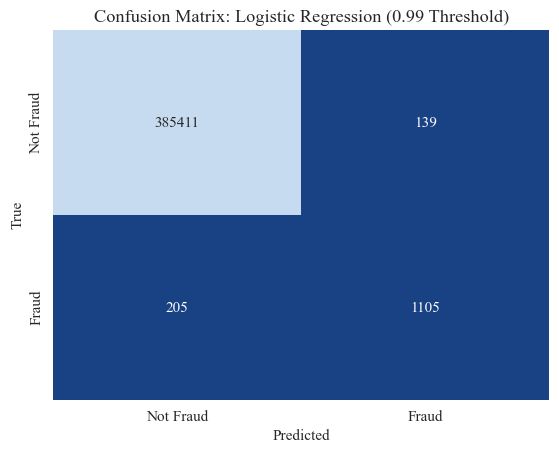

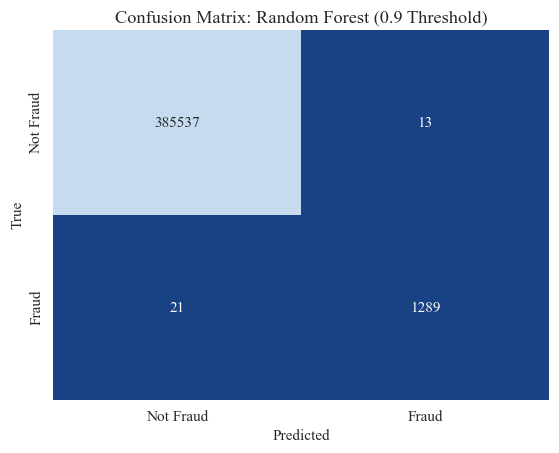

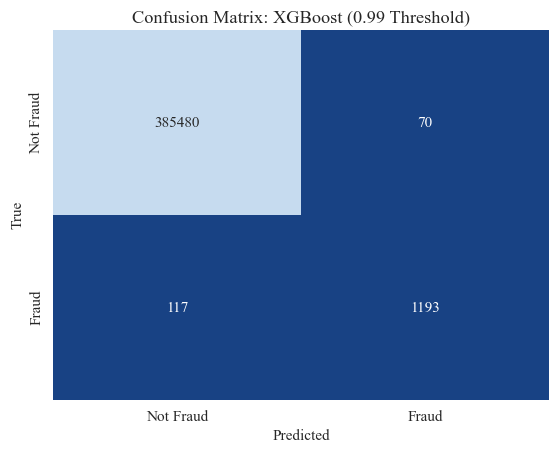

In [39]:
#Confusion Matrix
plot_confusion_matrix(y_test, logit_predictions_99, 'Confusion Matrix: Logistic Regression (0.99 Threshold)')
plot_confusion_matrix(y_test, rf_predictions_90, 'Confusion Matrix: Random Forest (0.9 Threshold)')
plot_confusion_matrix(y_test, xgb_predictions_99, 'Confusion Matrix: XGBoost (0.99 Threshold)')